In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.optimize import minimize 
from scipy.stats import binom

In [2]:
stock_returns = pd.read_excel("../Assignment2.xlsx", sheet_name="Monthly returns")

/home/olha/.local/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
stock_returns.head()

,Asset 1,Asset 2,Asset 3,Unnamed: 3,Estimated Mean,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,2.1675,-1.8883,3.0712,NaN,NaN,Asset 1,Asset 2,Asset 3,NaN,NaN,NaN,NaN
1,3.3875,-0.5608,1.2428,NaN,NaN,-0.51864,4.70574,-0.69862,NaN,NaN,NaN,NaN
2,-2.5194,1.5773,-3.1840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.3959,1.4225,3.0923,NaN,Estimated Covariance matrix,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-2.7264,1.0408,-0.0131,NaN,NaN,Asset 1,Asset 2,Asset 3,NaN,NaN,NaN,NaN


In [4]:
stok_returns_matr = stock_returns.drop(columns=["Unnamed: 3", "Estimated Mean","Unnamed: 5", "Unnamed: 6",
                                                "Unnamed: 7", "Unnamed: 8", "Unnamed: 9", "Unnamed: 10",
                                               "Unnamed: 11", ])

stok_returns_matr = stok_returns_matr[:60]
stok_returns_matr.head()

,Asset 1,Asset 2,Asset 3
0,2.1675,-1.8883,3.0712
1,3.3875,-0.5608,1.2428
2,-2.5194,1.5773,-3.1840
3,-1.3959,1.4225,3.0923
4,-2.7264,1.0408,-0.0131


In [5]:
mean_return_matrix = stok_returns_matr.mean() *12 / 100
mean_return_matrix 

Asset 1   -0.005186
Asset 2    0.047057
Asset 3   -0.006986
dtype: float64

In [6]:
# cov_matrix = stok_returns_matr.cov()
# cov_matrix / 1000

In [7]:
cov_matrix = np.array([ [0.0056,	-0.0020,	0.0037],
                        [-0.0020,	0.0022,	-0.0022],
                        [0.0037,	-0.0022,	0.0074] ])

cov_matrix

array([[ 0.0056, -0.002 ,  0.0037],
       [-0.002 ,  0.0022, -0.0022],
       [ 0.0037, -0.0022,  0.0074]])

In [8]:
risk_free_rate = 0.01

In [9]:
def sharpe_direction_closed_form(V, mu, rf):
    V = np.asarray(V, float)
    mu = np.asarray(mu, float)
    n = mu.size
    ones = np.ones(n)
    a = mu - rf * ones

    V = 0.5 * (V + V.T)

    # Solve V y = a  (more stable than explicitly inverting V)
    y = np.linalg.solve(V, a)
    x_star = y / (a @ y)

    w_star = x_star / (ones @ x_star)
    return x_star, w_star

In [10]:
x_star, w_star = sharpe_direction_closed_form(cov_matrix, mean_return_matrix, risk_free_rate)
w_star

array([0.12671194, 0.78257157, 0.09071648])

In [11]:
print("portfolio mean return : ", round(np.sum(w_star * mean_return_matrix), 4))
print("vol:", round(np.sqrt(w_star.T @ cov_matrix @ w_star)*100, 6))
print("variance:", round(w_star.T @ cov_matrix @ w_star, 6))

portfolio mean return :  0.0355
vol: 2.956659
variance: 0.000874


In [12]:
mu_T = np.sum(w_star * mean_return_matrix)
vol_T = np.sqrt(w_star.T @ cov_matrix @ w_star)
variance_T = w_star.T @ cov_matrix @ w_star

In [13]:
target_vol = 0.05

In [14]:
risky_weights = target_vol / vol_T
risky_weights

np.float64(1.691097840683929)

In [15]:
risk_free_weights = 1 - risky_weights
risk_free_weights

np.float64(-0.691097840683929)

In [16]:
port_return = risk_free_rate + risky_weights * (mu_T - risk_free_rate)
round(port_return * 100,2)

np.float64(5.32)

## Realized portfolio return

In [17]:
# Sharpe optimization output
w_tan = w_star

# # Tangency portfolio volatility
# sigma_T = np.sqrt(w_tan @ cov_matrix @ w_tan)

# Scale to 5% volatility
alpha = 0.05 / vol_T
w_risky = alpha * w_tan
w_rf = 1 - alpha


In [18]:
w_risky

array([0.2142823 , 1.32340509, 0.15341045])

In [46]:
round(np.sum(stok_returns_matr @ w_risky) *12 / 100, 2)

np.float64(3.61)

## compute the probability that manager that has no skills p=0.5 outperforms market in 14 from 15 years

In [19]:
n = 15  # Number of years
p = 0.5 # Probability of success 
k = 14  # Number of successfull years

In [20]:
def outperf_market(n, p, k):
    prob_total = 0
    for i in range(k,n+1, 1):
        prob_total += binom.pmf(i, n, p)
    
    return prob_total

In [21]:
prob_outperf = outperf_market(n, p, k)
round(prob_outperf, 4)

np.float64(0.0005)

## probability that the best of M=100 managers had a track record as good as or better than this (outperform the market 14 times out of 15)

In [22]:
def prob_best_manager(prob_total, M):
    return 1- ((1-prob_total) ** M)

In [23]:
M = 100
round(prob_best_manager(prob_outperf, M), 4)

np.float64(0.0477)

## compute the probability that manager that has no skills p=0.5 outperforms market in 12 from 15 years

In [24]:
n1 = 15  # Number of years
p1 = 0.5 # Probability of success 
k1 = 12  # Number of successfull years

p1 = outperf_market(n1, p1, k1)
round(p1,4)

np.float64(0.0176)

## VaR at 90% probability level 

In [25]:
var_returns = pd.read_excel("../Assignment2.xlsx", sheet_name="Value_at_risk")

/home/olha/.local/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [26]:
var_returns.head()

,Asset 1,Asset 2,Asset 3,Unnamed: 3,Equally weighted loss,Unnamed: 5,Unnamed: 6
0,2.1675,-1.8883,3.0712,NaN,-1.116800,NaN,NaN
1,3.3875,-0.5608,1.2428,NaN,-1.356500,NaN,NaN
2,-2.5194,1.5773,-3.1840,NaN,1.375367,NaN,NaN
3,-1.3959,1.4225,3.0923,NaN,-1.039633,NaN,NaN
4,-2.7264,1.0408,-0.0131,NaN,0.566233,NaN,NaN


In [27]:
var_returns_matr = var_returns.drop(columns=["Unnamed: 3", "Equally weighted loss",
                                                "Unnamed: 5", "Unnamed: 6"])

In [28]:
var_returns_matr.head()

,Asset 1,Asset 2,Asset 3
0,2.1675,-1.8883,3.0712
1,3.3875,-0.5608,1.2428
2,-2.5194,1.5773,-3.1840
3,-1.3959,1.4225,3.0923
4,-2.7264,1.0408,-0.0131


In [29]:
eq_weight_loss = -  var_returns_matr[["Asset 1", "Asset 2", "Asset 3"]].mean(axis=1)
eq_weight_loss

0    -1.116800
1    -1.356500
2     1.375367
3    -1.039633
4     0.566233
5    -0.004967
6    -1.909200
7     1.103900
8    -0.233233
9    -0.667767
10   -1.304533
11    0.822867
12    0.961633
13   -0.968533
14    1.063100
15   -2.888767
16    0.602200
17    1.120433
18   -0.951133
19    0.081033
20   -0.861900
21    0.068467
22   -0.205333
23    0.956500
24    0.179533
25   -2.456500
26   -0.065600
27   -0.194233
28    0.347100
29   -0.256367
30    1.292267
31   -0.304533
32    0.461933
33   -1.881900
34   -1.139733
35    1.987667
36   -0.095967
37    1.044033
38   -0.272167
39   -0.021833
40    0.814033
41    1.919133
42    2.145000
43   -0.392433
44    0.884567
45   -2.056867
46   -0.869867
47   -0.455067
48   -0.511400
49   -0.041167
50    0.251467
51   -0.607667
52    1.880733
53   -0.275567
54   -1.263933
55   -1.491567
56   -0.939533
57    2.370733
58   -0.275867
59   -0.736000
dtype: float64

Text(0.5, 0, 'Loss')

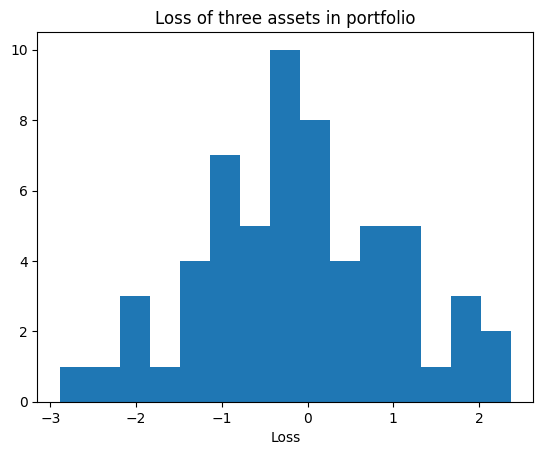

In [30]:
plt.hist(eq_weight_loss, bins = 15)
plt.title("Loss of three assets in portfolio")
plt.xlabel("Loss")

In [31]:
losses_df = pd.DataFrame(eq_weight_loss, columns=["loss_value"])
losses_df.head()

,loss_value
0,-1.116800
1,-1.356500
2,1.375367
3,-1.039633
4,0.566233


In [32]:
p_90 = 0.9
N = len(eq_weight_loss)
Kp = int(np.ceil(p_90 * N))

sorted_losses = np.sort(eq_weight_loss)
VaR2 = sorted_losses[Kp - 1]  
round(VaR2, 2)

np.float64(1.29)

In [33]:
CVaR3 = np.sum(sorted_losses[Kp - 1 :]) / ((1 - p_90)*N)

In [34]:
round(CVaR3, 2)

np.float64(2.16)